<div> 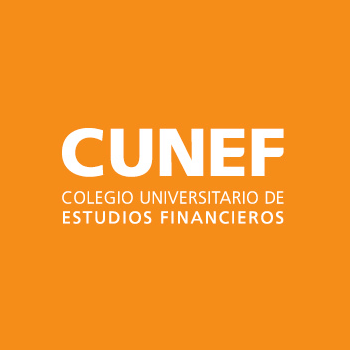
</div>


# **Hipotecas en España**
En este notebook se mostrará la serie temporal del **número de hipotecas en España** y observaremos cómo afectó ésta frente al COVID-19. 



Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## *2) Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV del número de hipotecas del TOTAL DE FINCAS en España.

- Fuente: https://datos.gob.es/es/catalogo/ea0010587-hipotecas-constituidas-sobre-el-total-de-fincas-por-naturaleza-de-la-finca-mensual-comunidades-autonomas-estadistica-de-hipotecas-identificador-api-138961

In [3]:
df_hipotecas = pd.read_csv("hipotecas2.csv", sep = ";", on_bad_lines='skip')
df_hipotecas

,Comunidades Autonomas,Naturaleza de la finca,Número e importe,Periodo,Total
0,Total Nacional,Total fincas,Número de hipotecas,2022M05,57.463
1,Total Nacional,Total fincas,Número de hipotecas,2022M04,44.230
2,Total Nacional,Total fincas,Número de hipotecas,2022M03,57.760
3,Total Nacional,Total fincas,Número de hipotecas,2022M02,49.147
4,Total Nacional,Total fincas,Número de hipotecas,2022M01,46.946
...,...,...,...,...,...
55915,"17 Rioja, La",Otros,Importe de hipotecas,2003M05,25.726
55916,"17 Rioja, La",Otros,Importe de hipotecas,2003M04,14.410
55917,"17 Rioja, La",Otros,Importe de hipotecas,2003M03,14.926
55918,"17 Rioja, La",Otros,Importe de hipotecas,2003M02,8.950


Observamos que el DataFrame que nos lee Jupyter Notebook tiene varios valores en las filas en cada variable, vamos a mirar qué contiene en las variables "Comunidades Autónomas" y "Naturaleza de la finca" por si nos interesa para algo en nuestro análisis:

In [4]:
df_hipotecas['Comunidades Autonomas'].unique()

array(['Total Nacional', '01 Andalucía', '02 Aragón',
       '03 Asturias, Principado de', '04 Balears, Illes', '05 Canarias',
       '06 Cantabria', '08 Castilla - La Mancha', '07 Castilla y León',
       '09 Cataluña', '18 Ceuta', '10 Comunitat Valenciana',
       '11 Extremadura', '12 Galicia', '13 Madrid, Comunidad de',
       '19 Melilla', '14 Murcia, Región de',
       '15 Navarra, Comunidad Foral de', '16 País Vasco', '17 Rioja, La'],
      dtype=object)

In [5]:
df_hipotecas['Naturaleza de la finca'].unique()

array(['Total fincas', 'Total fincas rústicas', 'Total fincas urbanas',
       'Viviendas', 'Solares', 'Otros'], dtype=object)

Del DataFrame, lo único que nos interesa son los datos a nivel nacional y el número total de fincas que engloba todos los tipos de fincas e inmuebles que han habido (hasta la fila 231 del CSV)

In [6]:
df_hipotecas = df_hipotecas.iloc[0:230, 0:5]
df_hipotecas

,Comunidades Autonomas,Naturaleza de la finca,Número e importe,Periodo,Total
0,Total Nacional,Total fincas,Número de hipotecas,2022M05,57.463
1,Total Nacional,Total fincas,Número de hipotecas,2022M04,44.230
2,Total Nacional,Total fincas,Número de hipotecas,2022M03,57.760
3,Total Nacional,Total fincas,Número de hipotecas,2022M02,49.147
4,Total Nacional,Total fincas,Número de hipotecas,2022M01,46.946
...,...,...,...,...,...
225,Total Nacional,Total fincas,Número de hipotecas,2003M08,92.580
226,Total Nacional,Total fincas,Número de hipotecas,2003M07,113.881
227,Total Nacional,Total fincas,Número de hipotecas,2003M06,113.086
228,Total Nacional,Total fincas,Número de hipotecas,2003M05,116.615


Comprobamos que solo tenemos los valores totales nacionales, total de fincas y solo hipotecas:

In [7]:
df_hipotecas['Comunidades Autonomas'].unique()

array(['Total Nacional'], dtype=object)

In [8]:
df_hipotecas['Naturaleza de la finca'].unique()

array(['Total fincas'], dtype=object)

In [9]:
df_hipotecas['Número e importe'].unique()

array(['Número de hipotecas'], dtype=object)

Una vez comprobadas que en las columnas solo están los datos que queremos, como ya no nos sirve para nada las variables de "Comunidades Autónomas, "Naturaleza de la finca" y "Número e importe", hacemos otro iloc para quitarlas y ya solamente nos centramos en trabajar con los datos del total de hipotecas:

In [10]:
df_hipotecas = df_hipotecas.iloc[:, 3:5]
df_hipotecas

,Periodo,Total
0,2022M05,57.463
1,2022M04,44.230
2,2022M03,57.760
3,2022M02,49.147
4,2022M01,46.946
...,...,...
225,2003M08,92.580
226,2003M07,113.881
227,2003M06,113.086
228,2003M05,116.615


In [11]:
# Convertimos en formato fecha
df_hipotecas['Periodo'] = df_hipotecas['Periodo'].str.replace('M', '')
df_hipotecas['Periodo'] = pd.to_datetime(df_hipotecas['Periodo'], format='%Y%m')

Cambiamos el formato de la fecha y cambiamos el formato del número quitando el punto separador de millares:

In [12]:
df_hipotecas = df_hipotecas.set_index("Periodo")
df_hipotecas

,Total
Periodo,
2022-05-01,57.463
2022-04-01,44.230
2022-03-01,57.760
2022-02-01,49.147
2022-01-01,46.946
...,...
2003-08-01,92.580
2003-07-01,113.881
2003-06-01,113.086


In [13]:
df_hipotecas['Total']=df_hipotecas['Total'].str.replace('.', '').astype(float)
df_hipotecas=df_hipotecas.iloc[::-1]
df_hipotecas

,Total
Periodo,
2003-04-01,104744.0
2003-05-01,116615.0
2003-06-01,113086.0
2003-07-01,113881.0
2003-08-01,92580.0
...,...
2022-01-01,46946.0
2022-02-01,49147.0
2022-03-01,57760.0


## *3) EDA*

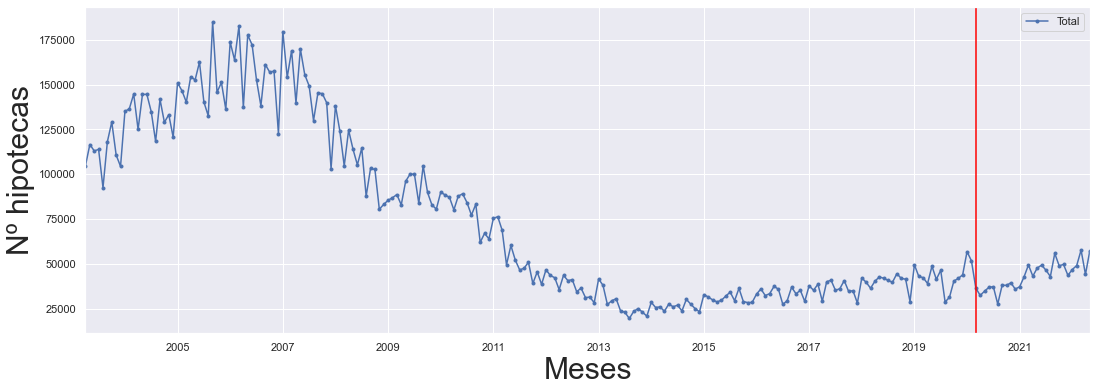

In [14]:
sns.set(rc={'figure.figsize':(18, 6)})
fig = df_hipotecas.plot(marker='.') 
fig.set_ylabel('Nº hipotecas', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);

Se puede apreciar en la gráfica que los números máximos de hipotecas estuvo comprendido entre el año 2005 y 2007, y que a partir del 2008 empezó a bajar el número de ventas de inmuebles. Esto puede ser debido a la crisis financiera de la época. De todos modos, estos datos distorsionan demasiado el análisis que queremos realizar, por lo que seleccionaremos los datos más recientes. Vamos a aplicar un zoom desde el 2014 en adelante:

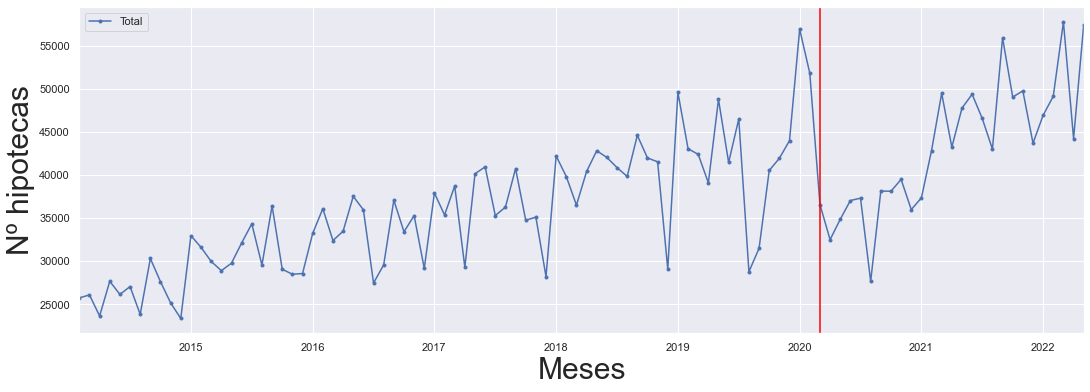

In [15]:
df_hipotecas =  df_hipotecas.iloc[130:]

sns.set(rc={'figure.figsize':(18, 6)})
fig = df_hipotecas.plot(marker='.') 
fig.set_ylabel('Nº hipotecas', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30);
# fig.figure.savefig('../pics/df_hipotecas/tendencias.png')

La gráfica presenta una tendencia creciente con una caída en el momento COVID. Debido al confinamiento, no ha habido ventas de inmuebles y se puede reflejar en los meses siguientes a los de febrero del 2020. Sin embargo, a día de hoy la tendencia se está recuperando y está siendo creciente.

A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

Para que no nos afecte al análisis la situación anómala provocada por COVID-19, **analizaremos sólamente hasta el último mes antes del inicio de la pandemia**, esto es, **el mes de febrero del 2020**.

In [16]:
df_hipotecas_eda=df_hipotecas.iloc[:73,:]
df_hipotecas_eda

,Total
Periodo,
2014-02-01,25763.0
2014-03-01,26111.0
2014-04-01,23663.0
2014-05-01,27690.0
2014-06-01,26168.0
...,...
2019-10-01,40538.0
2019-11-01,41947.0
2019-12-01,44001.0


### 3.1) Cálculo de la media y de la varianza

In [17]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media=split_and_summarize(df_hipotecas_eda, 'Total', 4, np.mean)
varianza=split_and_summarize(df_hipotecas_eda, 'Total', 4, np.var)

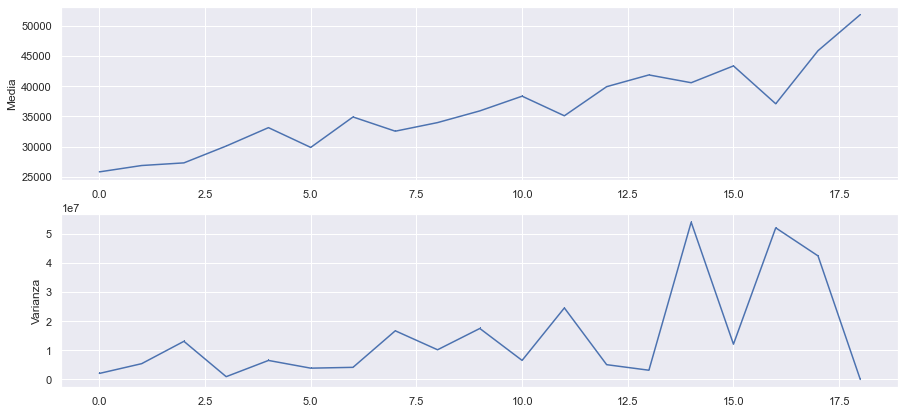

In [18]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()
# fig.figure.savefig('../pics/df_hipotecas/meanvariance.png')

A simple vista la media y la varianza no son constantes a lo largo del tiempo. Vamos a observarlo con el Test de Dickey-Fuller aumentado.

### 3.2. Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [19]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_hipotecas_eda)

Results of Dickey-Fuller Test:
Test Statistic                 -1.302589
p-value                         0.627987
#Lags Used                     11.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


**La serie temporal NO es estacionaria**, debido a que el p-value del test Dickey-Fuller (0.62) es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-1.3) es mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

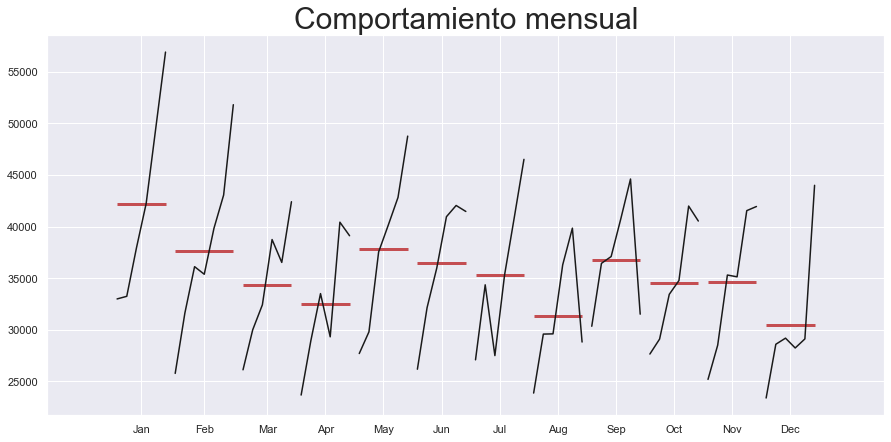

In [20]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_hipotecas_eda['Total'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_hipotecas/monthbehavior.png')

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

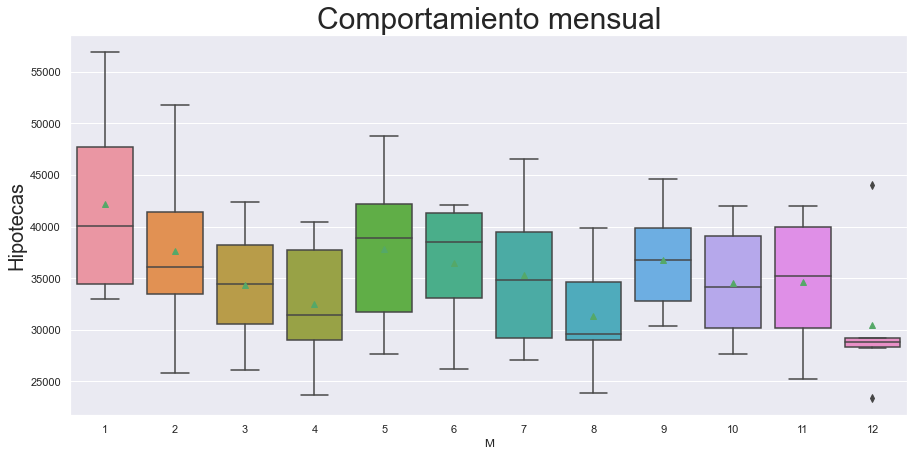

In [21]:
df_hipotecas_eda['M'] = df_hipotecas_eda.index.month
sns.boxplot(data = df_hipotecas_eda, x = 'M', y='Total', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Hipotecas', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);
# ax.figure.savefig('../pics/df_hipotecas/boxplotmonth.png')

Se puede apreciar que los meses que más se hipotecan inmuebles son los meses de enero y mayo, por encima de las 40.000 hipotecas. Sin embargo, los meses que menos hipotecas se realizan son abril, agosto y diciembre. Se observan datos atípicos en el mes de diciembre.

### 3.4.) Descomposición

Y, por último, vamos a realizar la descomposición de la serie temporal de las hipotecas, que nos indica de un solo vistazo la estacionalidad, la tendencia y los residuos:

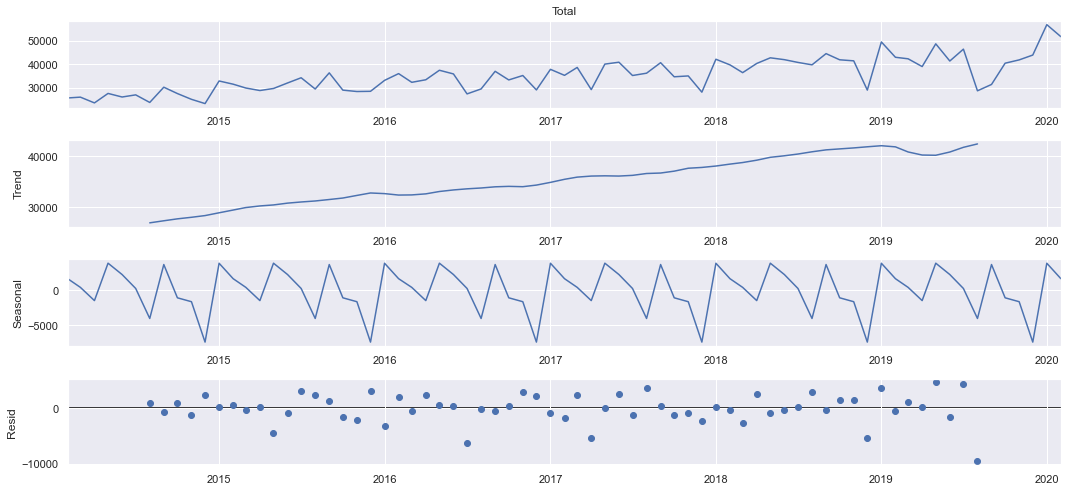

In [22]:
desglose = seasonal_decompose(df_hipotecas_eda['Total'], 
                                   model='additive', 
                                   period=12);
desglose.plot();
# plt.savefig('../pics/df_hipotecas/decompose.png')

Analizando las gráficas, observamos:
- **La tendencia es creciente**.
- **Se aprecia estacionalidad**.
- **No se trata de una serie estacionaria** debido a la irregularidad que hay en la media y en la varianza.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta mayo del 2022, hay 27 meses para el test_size.



Cantidad de períodos en Train: 73
Cantidad de períodos en Test: 27


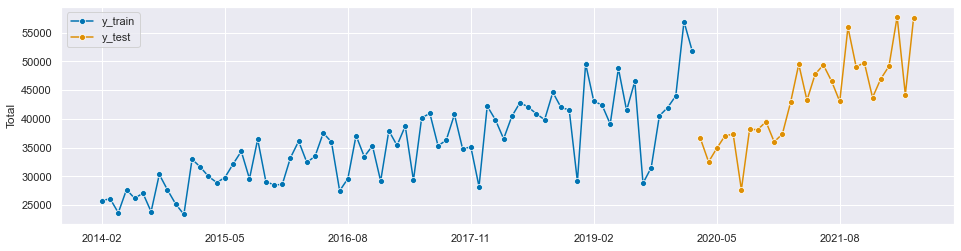

In [23]:
#Train-test
y_train, y_test = temporal_train_test_split(y = df_hipotecas['Total'].astype('float64').to_period('M'), 
                                            test_size=27)
#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [24]:
y_test #observamos los 27 meses testeados

2020-03    36588.0
2020-04    32516.0
2020-05    34877.0
2020-06    37054.0
2020-07    37329.0
2020-08    27682.0
2020-09    38155.0
2020-10    38132.0
2020-11    39501.0
2020-12    36007.0
2021-01    37355.0
2021-02    42850.0
2021-03    49490.0
2021-04    43241.0
2021-05    47769.0
2021-06    49382.0
2021-07    46566.0
2021-08    43018.0
2021-09    55925.0
2021-10    49053.0
2021-11    49768.0
2021-12    43702.0
2022-01    46946.0
2022-02    49147.0
2022-03    57760.0
2022-04    44230.0
2022-05    57463.0
Freq: M, Name: Total, dtype: float64

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [25]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
hipotecas_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [26]:
hipotecas_auto_ets.fit(y_train)
hipotecas_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   73
Model:                       ETS(MAM)   Log Likelihood                -688.631
Date:                Thu, 01 Sep 2022   AIC                           1413.263
Time:                        08:05:56   BIC                           1454.491
Sample:                    02-28-2014   HQIC                          1429.693
                         - 02-29-2020   Scale                            0.007
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0109        nan        nan        nan         nan         nan
smoothing_trend         0.0109      0.012      0.926      0.354      -0.012       0.034
smoothing_seasonal   9.891e-05        nan        nan        nan         nan         nan
initial_level        2.643e+04   5795.717      4.561      0.000    1.51e+04    3.78e+04
initial_trend         413.3212    250.964      1.647      0.100     -78.559     905.202
initial_seasonal.0      1.0878      0.256      4.250      0.000       0.586       1.589
initial_seasonal.1      0.7997      0.191      4.179      0.000       0.425       1.175
initial_seasonal.2      0.9048      0.210      4.301      0.000       0.492       1.317
initial_seasonal.3      0.9148      0.212      4.319      0.000       0.500       1.330
initial_seasonal.4      1.0125      0.233      4.351      0.000       0.556       1.469
initial_seasonal.5      0.8600      0.196      4.381      0.000       0.475       1.245
initial_seasonal.6      0.9614      0.223      4.305      0.000       0.524       1.399
initial_seasonal.7      0.9935      0.228      4.357      0.000       0.547       1.440
initial_seasonal.8      1.0322      0.237      4.350      0.000       0.567       1.497
initial_seasonal.9      0.9039      0.207      4.361      0.000       0.498       1.310
initial_seasonal.10     0.9589      0.220      4.366      0.000       0.528       1.389
initial_seasonal.11     1.0000      0.227      4.396      0.000       0.554       1.446
===================================================================================
Ljung-Box (Q):                       20.42   Jarque-Bera (JB):                24.17
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               4.91   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [27]:
#step 5: querying predictions
hipotecas_pred = hipotecas_auto_ets.predict(fh=list(fh))
hipotecas_pred.round()

2020-03    44939.0
2020-04    42676.0
2020-05    49094.0
2020-06    47601.0
2020-07    46402.0
2020-08    41806.0
2020-09    49576.0
2020-10    45112.0
2020-11    44937.0
2020-12    39995.0
2021-01    54787.0
2021-02    50714.0
2021-03    48966.0
2021-04    46471.0
2021-05    53428.0
2021-06    51773.0
2021-07    50439.0
2021-08    45417.0
2021-09    53828.0
2021-10    48954.0
2021-11    48737.0
2021-12    43353.0
2022-01    59355.0
2022-02    54913.0
2022-03    52992.0
2022-04    50267.0
2022-05    57762.0
Freq: M, dtype: float64

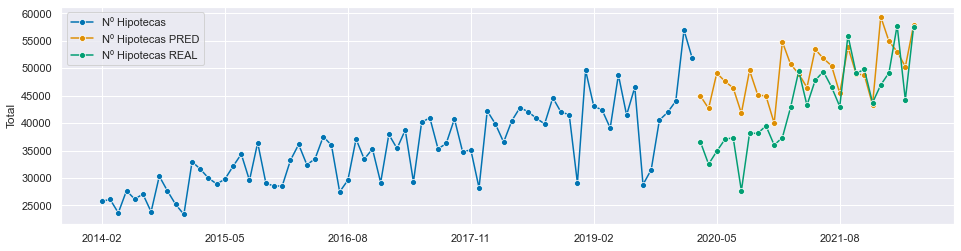

In [28]:
# optional: plotting predictions and past data
plot_series(y_train, hipotecas_pred, y_test,
            labels=["Nº Hipotecas", "Nº Hipotecas PRED", "Nº Hipotecas REAL"])
plt.show()

Se hace un zoom al gráfico:

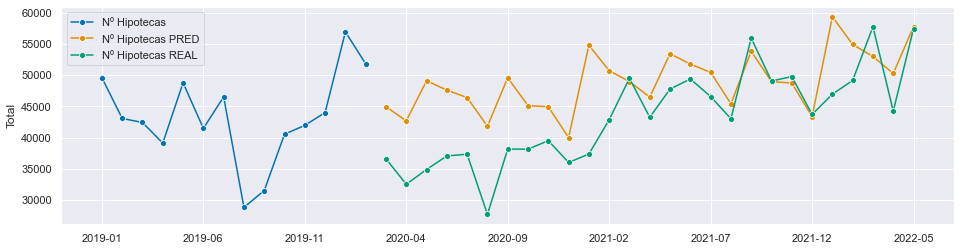

In [29]:
plot_series(y_train["2019":], hipotecas_pred,y_test,
            labels=["Nº Hipotecas", "Nº Hipotecas PRED", "Nº Hipotecas REAL"]);

La predicción por ETS, a simple vista, no predice con mucha certeza el momento del inicio de la pandemia, pero a partir de marzo del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [30]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, hipotecas_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 7887.57


In [31]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, hipotecas_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 16.42%


### 4.2) Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, aplicaremos logaritmo y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [32]:
transformer = LogTransformer()
log_df_hipotecas= transformer.fit_transform(df_hipotecas['Total'])
log_df_hipotecas.tail()

Periodo
2022-01-01    10.756753
2022-02-01    10.802571
2022-03-01    10.964052
2022-04-01    10.697159
2022-05-01    10.958897
dtype: float64

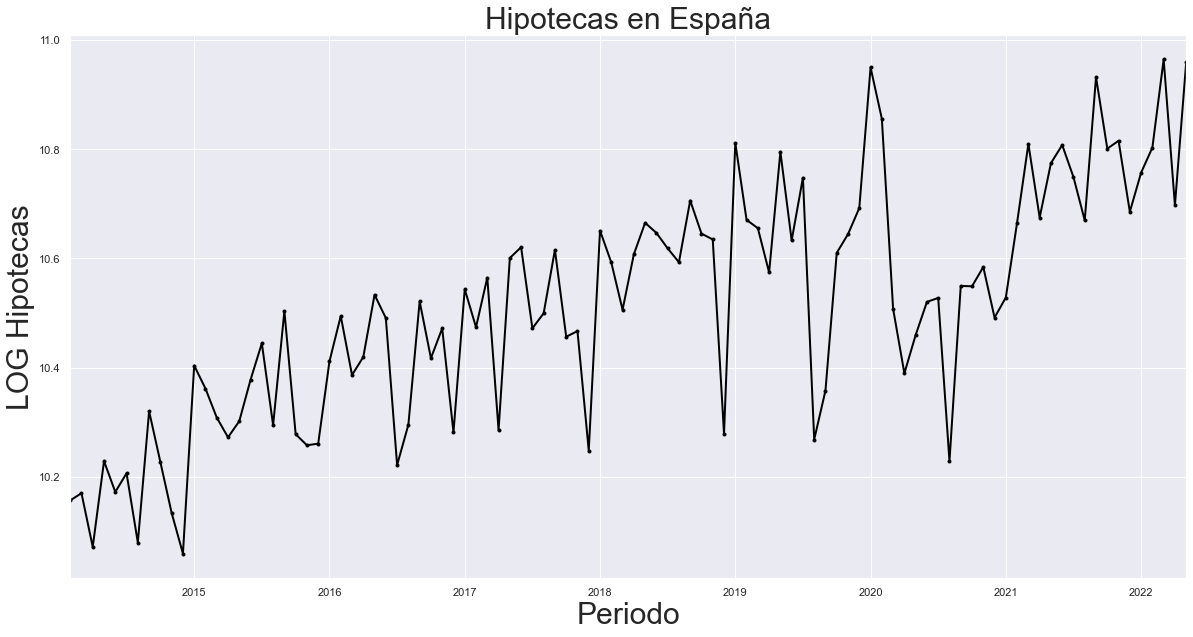

In [33]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_hipotecas.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Hipotecas en España', fontsize = 30) 
fig.set_ylabel('LOG Hipotecas', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y test a la serie transformada en logs:

73 27


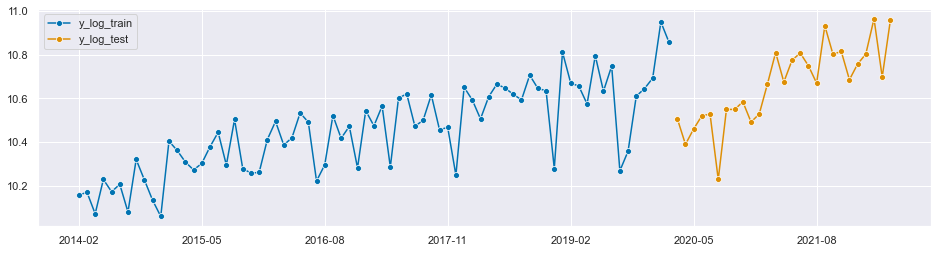

In [34]:
y_log_train,y_log_test=temporal_train_test_split(
    y=log_df_hipotecas.astype('float64').to_period('M').sort_index(),test_size=27)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [35]:
fh = np.arange(1,y_log_test.shape[0]+1)
hipotecas_auto_arima=AutoARIMA(d=1,D=1,sp=12,suppress_warnings=True)

In [36]:
hipotecas_auto_arima.fit(y_log_train)
hipotecas_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   73
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  36.986
Date:                              Thu, 01 Sep 2022   AIC                            -65.971
Time:                                      08:06:23   BIC                            -57.594
Sample:                                           0   HQIC                           -62.694
                                               - 73                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5070      0.088     -5.791      0.000      -0.679      -0.335
ar.L2         -0.1975      0.117     -1.687      0.092      -0.427       0.032
ma.S.L12      -0.8015      0.401     -2.000      0.046      -1.587      -0.016
sigma2         0.0140      0.004      3.299      0.001       0.006       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 8.57
Prob(Q):                              0.87   Prob(JB):                         0.01
Heteroskedasticity (H):               3.14   Skew:                            -0.45
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
hipotecas_log_pred = hipotecas_auto_arima.predict(fh)
np.exp(hipotecas_log_pred)

2020-03    52415.110518
2020-04    48879.269130
2020-05    57015.957293
2020-06    54879.261992
2020-07    53210.435253
2020-08    46400.146394
2020-09    54113.624993
2020-10    52152.177782
2020-11    52197.213251
2020-12    45787.807511
2021-01    63843.456324
2021-02    59837.357854
2021-03    58763.227324
2021-04    55307.842392
2021-05    64589.296912
2021-06    62019.067771
2021-07    60192.932598
2021-08    52487.513095
2021-09    61201.787933
2021-10    58989.191559
2021-11    59039.326545
2021-12    51789.119750
2022-01    72211.934003
2022-02    67680.581429
2022-03    66465.611353
2022-04    62557.360683
2022-05    73055.370568
Freq: M, dtype: float64

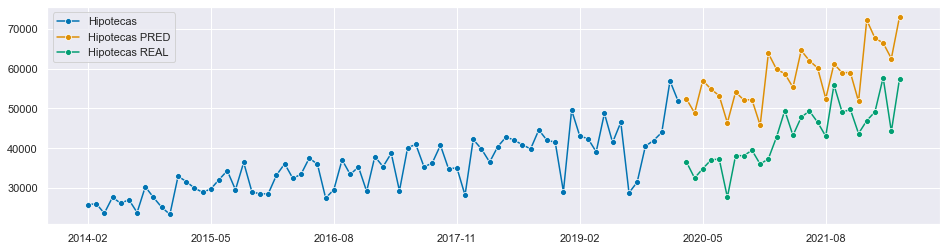

In [38]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(hipotecas_log_pred), np.exp(y_log_test), 
            labels=["Hipotecas", "Hipotecas PRED", "Hipotecas REAL"])
plt.show()

In [39]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(hipotecas_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 15505.32


In [40]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(hipotecas_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 35.72%


#### Una comparativa entre ETS y ARIMA

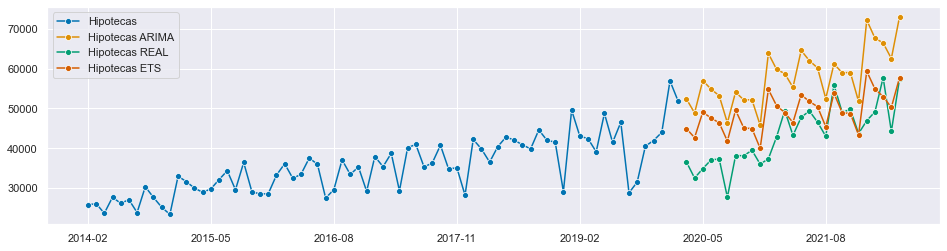

In [41]:
plot_series(np.exp(y_log_train["2013":]), np.exp(hipotecas_log_pred), np.exp(y_log_test), hipotecas_pred, 
            labels=["Hipotecas", "Hipotecas ARIMA", "Hipotecas REAL", 'Hipotecas ETS'])
plt.show()
# plt.savefig('../pics/df_hipotecas/etsarima.png')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [42]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 7887.57
El modelo ARIMA genera un RMSE de: 15505.32


In [43]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 16.42%
El modelo ARIMA genera un MAPE de 35.72%


### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [44]:
prophet_train = df_hipotecas.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [45]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

73

In [46]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

27

In [47]:
prophet_y_train.tail()

,ds,y
68,2019-10-31,40538.0
69,2019-11-30,41947.0
70,2019-12-31,44001.0
71,2020-01-31,56921.0
72,2020-02-29,51818.0


In [48]:
prophet_y_test.head()

,ds,y
0,2020-03-31,36588.0
1,2020-04-30,32516.0
2,2020-05-31,34877.0
3,2020-06-30,37054.0
4,2020-07-31,37329.0


In [49]:
m = Prophet()
m.fit(prophet_y_train)

08:06:24 - cmdstanpy - INFO - Chain [1] start processing
08:06:25 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

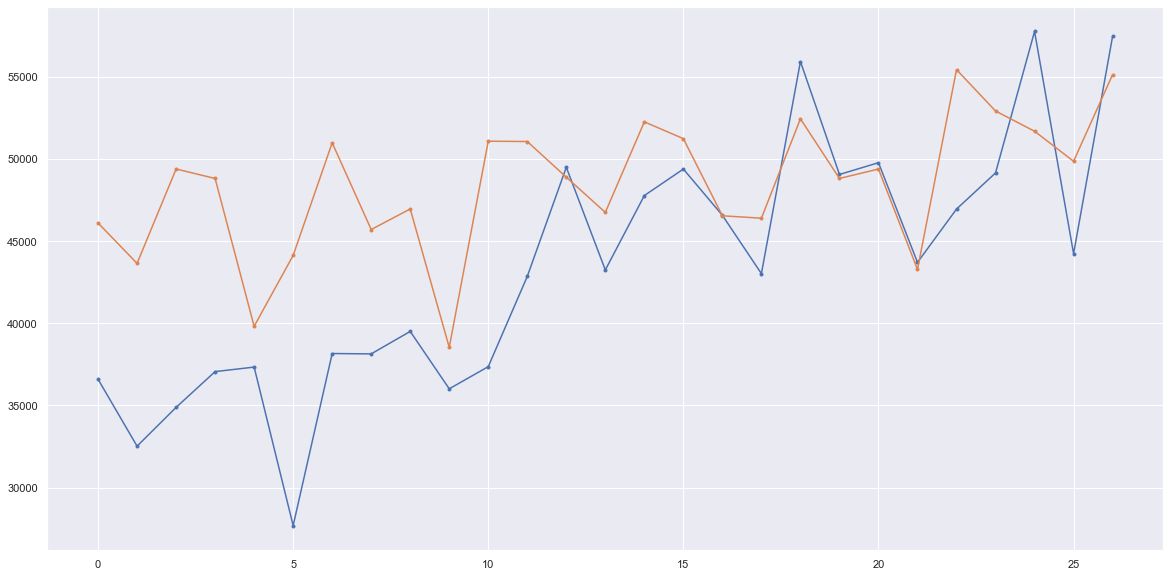

In [51]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[73:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_hipotecas/prophet.png')

In [52]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[73:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 15.8%


In [53]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[73:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 7696.12


In [54]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
95,2022-01-31,55432.0,51592.0,59138.0
96,2022-02-28,52915.0,49135.0,56565.0
97,2022-03-31,51684.0,48235.0,55371.0
98,2022-04-30,49857.0,45997.0,53693.0
99,2022-05-31,55131.0,51471.0,58937.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [55]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 7887.57
El modelo ARIMA genera un RMSE de: 15505.32
El modelo Prophet genera un RMSE de: 7696.12


2) MAPE (Error porcentual)

In [56]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 16.42%
El modelo ARIMA genera un MAPE de 35.72%
El modelo Prophet genera un MAPE de 15.8%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es el Prophet**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal de las hipotecas hasta finales de año, es decir, hasta diciembre del 2022 con el modelo Prophet. 

In [57]:
prophet_data = df_hipotecas.reset_index()
prophet_data.columns = ['ds', 'y']

08:06:27 - cmdstanpy - INFO - Chain [1] start processing
08:06:27 - cmdstanpy - INFO - Chain [1] done processing


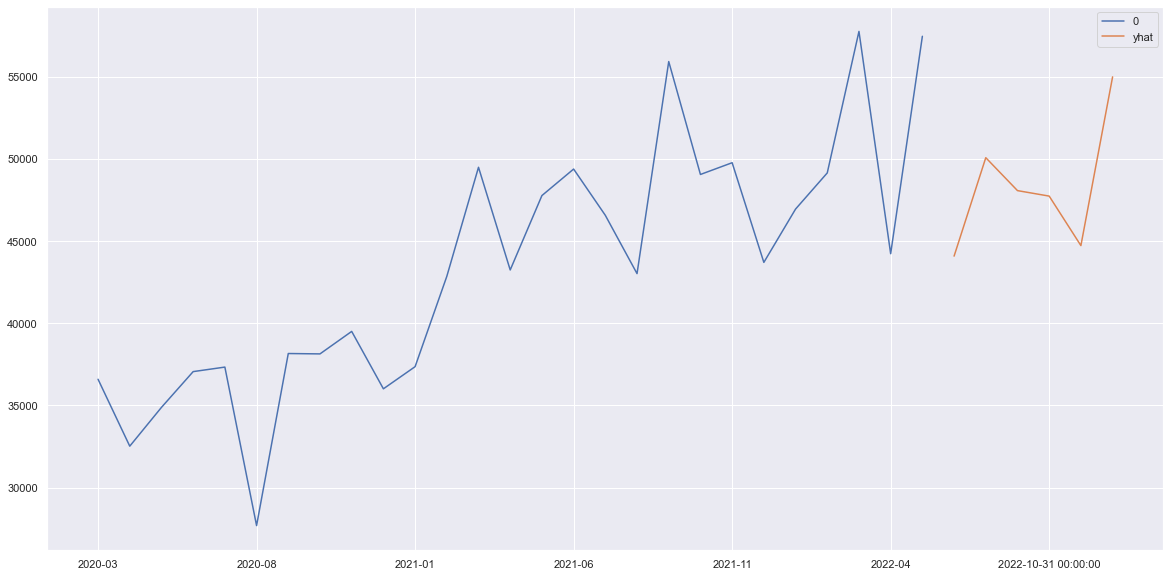


              Total
2020-08-01  27682.0
2020-09-01  38155.0
2020-10-01  38132.0
2020-11-01  39501.0
2020-12-01  36007.0
2021-01-01  37355.0
2021-02-01  42850.0
2021-03-01  49490.0
2021-04-01  43241.0
2021-05-01  47769.0
2021-06-01  49382.0
2021-07-01  46566.0
2021-08-01  43018.0
2021-09-01  55925.0
2021-10-01  49053.0
2021-11-01  49768.0
2021-12-01  43702.0
2022-01-01  46946.0
2022-02-01  49147.0
2022-03-01  57760.0
2022-04-01  44230.0
2022-05-01  57463.0
2022-05-31  49078.0
2022-06-30  49934.0
2022-07-31  44082.0
2022-08-31  50074.0
2022-09-30  48070.0
2022-10-31  47736.0
2022-11-30  44724.0
2022-12-31  54993.0


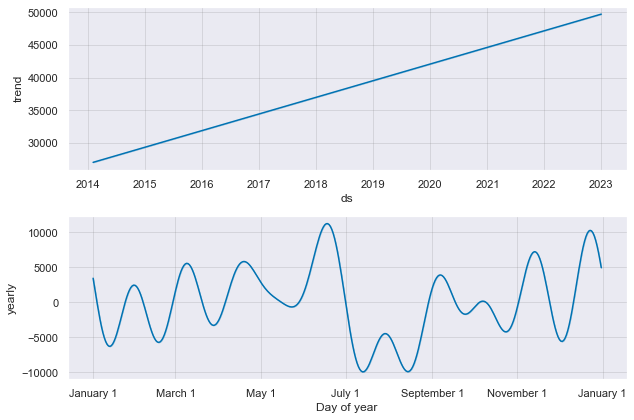

In [58]:
m = Prophet()
m.fit(prophet_data)
future = m.make_future_dataframe(periods=8, freq='M')
forecast = m.predict(future)
prophet_pred = forecast[['ds','yhat']].copy()
prophet_pred.set_index(['ds'], inplace=True)
pd.concat([y_test, prophet_pred.iloc[-6:].astype('int')]).plot()
# plt.savefig('images/diario/preddiaria.png')
plt.show();
print('')
pred = prophet_pred.rename_axis(index=None).rename(columns={'yhat': 'Total'}).iloc[-8:].astype('int')
data = df_hipotecas.append(pred)
print(data.tail(30))

fig2 = m.plot_components(forecast)
plt.show();

A continuación, en el Notebook "df_hipotecas_new" realizaremos una intervención quitando el momento COVID-19 para comprobar cuánta de diferencia hay en la precisión de la predicción cuando no hay un momento atípico.